In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

data = pd.read_csv("/home/mw/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1/Housing.csv")
data = data.dropna()

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

for col in categorical_columns:
    if data[col].nunique() <= 2:
        data[col] = LabelEncoder().fit_transform(data[col])
    else:
        one_hot = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data.drop(col, axis=1), one_hot], axis=1)

boolean_columns = data.select_dtypes(include='bool').columns
print(boolean_columns)
data[boolean_columns] = data[boolean_columns].astype(int)
print(data.dtypes)

numeric_columns = data.select_dtypes(include=['float64']).columns
data[numeric_columns] = (data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std()

data['area_standardized'] = (data['area'] - data['area'].mean()) / data['area'].std()
data['bedrooms_standardized'] = (data['bedrooms'] - data['bedrooms'].mean()) / data['bedrooms'].std()
data['bathrooms_standardized'] = (data['bathrooms'] - data['bathrooms'].mean()) / data['bathrooms'].std()
data['stories_standardized'] = (data['stories'] - data['stories'].mean()) / data['stories'].std()
data['parking_standardized'] = (data['parking'] - data['parking'].mean()) / data['parking'].std()

data = data.drop(columns=['area','bedrooms','bathrooms','stories', 'parking'])

print(data.columns)

target_column = "price"
features = data.drop(target_column, axis=1)
target = data[target_column]

print(features.head())

features_tensor = torch.tensor(features.values, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(features_tensor, target_tensor)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')
Index(['furnishingstatus_furnished', 'furnishingstatus_semi-furnished',
       'furnishingstatus_unfurnished'],
      dtype='object')
price                              int64
area                               int64
bedrooms                           int64
bathrooms                          int64
stories                            int64
mainroad                           int64
guestroom                          int64
basement                           int64
hotwaterheating                    int64
airconditioning                    int64
parking                            int64
prefarea                           int64
furnishingstatus_furnished         int64
furnishingstatus_semi-furnished    int64
furnishingstatus_unfurnished       int64
dtype: object
Index(['price', 'mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioni

In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc_output = nn.Linear(512, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        z = self.relu(self.fc3(z))
        reconstructed_x = self.sigmoid(self.fc_output(z))
        return reconstructed_x

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, log_var

    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

input_dim = features_tensor.shape[1]
print(input_dim)
latent_dim = 10

vae = VAE(input_dim, latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
reconstruction_loss_fn = nn.MSELoss(reduction="sum")

def vae_loss(reconstructed_x, x, mu, log_var):
    reconstruction_loss = reconstruction_loss_fn(reconstructed_x, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

num_epochs = 200
vae.train()

for epoch in range(num_epochs):
    epoch_loss = 0

    for batch in data_loader:
        features, _ = batch
        features = features.to(device)

        reconstructed_x, mu, log_var = vae(features)

        loss = vae_loss(reconstructed_x, features, mu, log_var)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
model_save_path = "vae_model.pth"
torch.save(vae.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

14
Epoch [1/200], Loss: 4468.3461
Epoch [2/200], Loss: 3902.3026
Epoch [3/200], Loss: 3657.7219
Epoch [4/200], Loss: 3634.8014
Epoch [5/200], Loss: 3621.7993
Epoch [6/200], Loss: 3617.5338
Epoch [7/200], Loss: 3603.5404
Epoch [8/200], Loss: 3602.3552
Epoch [9/200], Loss: 3596.2449
Epoch [10/200], Loss: 3597.6046
Epoch [11/200], Loss: 3597.1352
Epoch [12/200], Loss: 3592.3931
Epoch [13/200], Loss: 3591.0468
Epoch [14/200], Loss: 3593.1517
Epoch [15/200], Loss: 3597.0775
Epoch [16/200], Loss: 3593.9637
Epoch [17/200], Loss: 3588.9811
Epoch [18/200], Loss: 3590.5489
Epoch [19/200], Loss: 3590.5309
Epoch [20/200], Loss: 3589.0400
Epoch [21/200], Loss: 3587.6644
Epoch [22/200], Loss: 3593.3577
Epoch [23/200], Loss: 3587.0438
Epoch [24/200], Loss: 3591.2502
Epoch [25/200], Loss: 3589.6288
Epoch [26/200], Loss: 3593.8415
Epoch [27/200], Loss: 3585.4026
Epoch [28/200], Loss: 3593.4874
Epoch [29/200], Loss: 3586.3463
Epoch [30/200], Loss: 3593.2640
Epoch [31/200], Loss: 3599.9684
Epoch [32/200]

In [22]:
# Initialize the VAE architecture
vae = VAE(input_dim, latent_dim)
vae.load_state_dict(torch.load("vae_model.pth"))
vae.eval()  # Set to evaluation mode
print("Model loaded successfully.")


Model loaded successfully.


/tmp/ipykernel_51193/4121361854.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_model.pth"))


In [23]:
# Generate new samples
num_samples = 545
latent_dim = 10  # Ensure this matches the trained latent_dim
z = torch.randn((num_samples, latent_dim))  # Sample latent vectors
z = z.to(device)

# Pass latent vectors through the decoder
vae.to(device)
vae.eval()  # Ensure model is in evaluation mode
generated_data = vae.decoder(z)

print("Generated Data:")
print(generated_data)


Generated Data:
tensor([[8.0174e-01, 7.0501e-02, 2.2181e-01,  ..., 5.0236e-09, 1.2054e-09,
         3.6082e-09],
        [8.5251e-01, 1.6547e-01, 3.9130e-01,  ..., 7.3539e-04, 1.3534e-04,
         2.6633e-04],
        [8.8411e-01, 2.9391e-01, 4.0711e-01,  ..., 7.9290e-01, 5.6616e-01,
         3.3347e-01],
        ...,
        [8.5143e-01, 2.2105e-01, 4.3837e-01,  ..., 2.5777e-02, 5.6706e-03,
         9.1724e-03],
        [8.2794e-01, 1.8563e-01, 3.9513e-01,  ..., 1.7906e-03, 4.5335e-04,
         8.9192e-04],
        [7.4602e-01, 6.8649e-02, 1.7164e-01,  ..., 2.9376e-10, 7.3169e-11,
         1.8784e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)


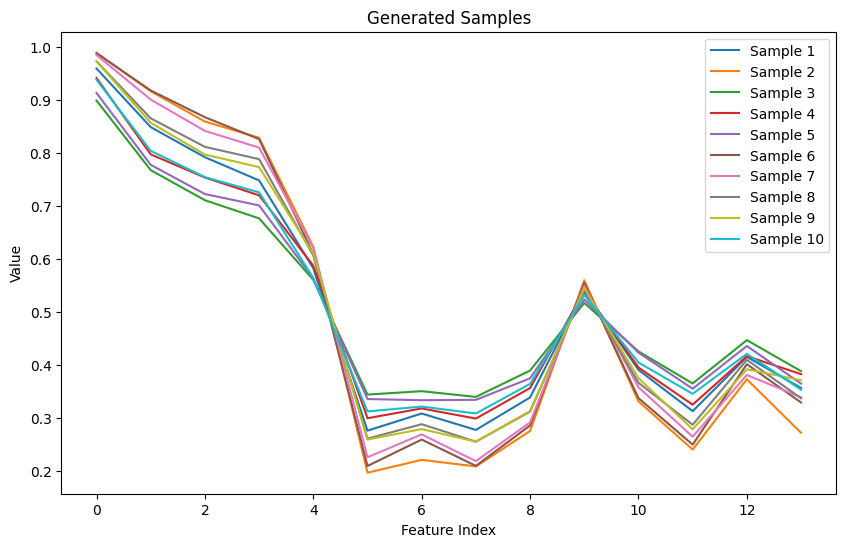

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Convert generated data to a NumPy array
data = generated_data.cpu().detach().numpy()

# Limit the number of samples to plot (e.g., first 10 or 20 samples)
num_samples_to_plot = min(len(data), 10)  # Plot only up to 20 samples

plt.figure(figsize=(10, 6))
for i, sample in enumerate(data[:num_samples_to_plot]):
    plt.plot(sample, label=f"Sample {i+1}")
    
plt.title("Generated Samples")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [24]:
features_tensor = features_tensor.to(generated_data.device)  # Move features_tensor to the same device as generated_data

# Compute MSE loss
from torch.nn.functional import mse_loss
loss = mse_loss(generated_data, features_tensor)
print(f"Reconstruction Loss (MSE): {loss.item()}")


Reconstruction Loss (MSE): 0.5135642290115356
